## <center>Fine tuning der VGG16 Gewichte für die Klassifizierung von Angestellten und Nicht-Angestellten</center>

Begonnen wird mit einer Funktion, um das Vorhandensein der erforderlichen Trainings- und Validierungsverzeichnisse zu überprüfen. Wenn keine Verzeichnisse vorhanden sind, werden sie automatisch erstellt und es wird ein Fehler ausgegeben, wenn keine Bilder für das Training verfügbar sind.

In [30]:
import os
base_dir = 'c:/data/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Create directories for trainging an validation
train_dir = os.path.join(base_dir,'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
validation_dir = os.path.join(base_dir,'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

train_employees_dir = os.path.join(train_dir,'employees')
if not os.path.exists(train_employees_dir):
    os.mkdir(train_employees_dir)

train_nonemployees_dir = os.path.join(train_dir,'nonemployees')
if not os.path.exists(train_nonemployees_dir):
    os.mkdir(train_nonemployees_dir)

validation_employees_dir = os.path.join(validation_dir,'employees')
if not os.path.exists(validation_employees_dir):
    os.mkdir(validation_employees_dir)

validation_nonemployees_dir = os.path.join(validation_dir, 'nonemployees')
if not os.path.exists(validation_nonemployees_dir):
    os.mkdir(validation_nonemployees_dir)
if not (os.listdir(train_employees_dir)or(os.listdir(train_nonemployees_dir))):
        print("Employ images in training directory is empty- You need to have images in this directory to start training")
else:    
    if not (os.listdir(validation_employees_dir)or(os.listdir(validation_nonemployees_dir))):
        print("Employ images in validation directory is empty- You need to have images in this directory to start training")
        


Employ images in training directory is empty- You need to have images in this directory to start training


Hier werden die VGG16-Netzwerkarchitektur und Gewichte ohne Eingabeebene heruntergeladen. Bei der ersten Verwendung werden die Gewichte heruntergeladen und in ~/.keras/models/vggface gespeichert.
Anschließend wird ein benutzerdefiniertes Modell (vgl. https://github.com/rcmalli/keras-vggface ), das die Anzahl der für das Training der Bilder erforderlichen Ebenen im Trainingsverzeichnis hinzufügt, erstellt.
Einfrieren aller Schichten mit Ausnahme der letzten vier ((: - 4)

In [29]:
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense
#from keras.models import Model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
#Lade das VGG-16 Netz
model_vgg16_conv = VGG16( include_top=False)
# Dimensionen des Eingabebilds
img_width, img_height = 224, 224
# Definiere die eigenen Dimensionen des Eingabebilds.
input = Input(shape=(224,224,3),name = 'image_input')

# Verwende das neue Modell 
output_vgg16_conv = model_vgg16_conv(input)
# Nur die letzen 4 Schichten trainierbar machen
for layer in model_vgg16_conv.layers[:-4]:
    layer.trainable = False
my_model = models.Sequential()
my_model.add(model_vgg16_conv)   
# Füge Fully-Connected Schichten hinzu 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)
 
my_model = Model(inputs=input, outputs=x)

In diesem Abschnitt werden die für das Training und die Validierung erforderlichen Parameter definiert. Die ImageDataGenerator-Funktion von Keras wird zur Bildmanipulation und Normalisierung verwendet.
Die Batchgröße für jede Iteration kann auch manuell bestimmt werden.
Flow_from_directory stellt sicher, dass alle im Verzeichnis vorhandenen Bilder für das Training und die Validierung iterativ verwendet werden.

In [27]:
# Den train_generator verwenden von der ImageDataGenerator Library von Keras
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Die Batchgröße gemäß der RAM anpassen
train_batchsize = 5
val_batchsize = 5
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_width, img_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=True)


NameError: name 'train_batchsize' is not defined

Hier wird die Funktion von Optimierern aus dem Keras Framework verwendet, um das neue Modell zu kompilieren. Es wurden verschiedene Versuche mit verschiedenen Arten von Optimierern unternommen, um die beste Ergebnisse zu erreichen. Das beste für die Datenmenge, die mit diesem Programm verwendet wurde, scheint der SGD mit der binären Kreuzentropie zu sein.

In [57]:
from keras import optimizers
my_model.compile(optimizer = "SGD", loss ='binary_crossentropy', metrics = ['accuracy'])

Nachdem das Modell erstellt wurde, wurde dieses an mehr als 300 Proben trainiert.

In [58]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
nb_train_samples = 385
nb_validation_samples = 67
epochs = 20
batch_size = 15
my_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
25/25 [==============================] - 72s 3s/step - loss: 3.2344 - acc: 0.7840 - val_loss: 7.2136 - val_acc: 0.5500
Epoch 2/20
25/25 [==============================] - 69s 3s/step - loss: 2.8213 - acc: 0.8240 - val_loss: 6.4121 - val_acc: 0.6000
Epoch 3/20
25/25 [==============================] - 68s 3s/step - loss: 2.9496 - acc: 0.8160 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 4/20
25/25 [==============================] - 67s 3s/step - loss: 2.8213 - acc: 0.8240 - val_loss: 7.5436 - val_acc: 0.5294
Epoch 5/20
25/25 [==============================] - 73s 3s/step - loss: 1.1257 - acc: 0.8160 - val_loss: 1.3896 - val_acc: 0.4000
Epoch 6/20
25/25 [==============================] - 69s 3s/step - loss: 0.3403 - acc: 0.8400 - val_loss: 0.8807 - val_acc: 0.4000
Epoch 7/20
25/25 [==============================] - 67s 3s/step - loss: 0.3573 - acc: 0.8240 - val_loss: 1.1981 - val_acc: 0.4706
Epoch 8/20
25/25 [==============================] - 68s 3s/step - loss: 0.2686 - acc: 0.88

Mit der Keras-Verlaufsfunktion kann die durchschnittliche Trainingsgenauigkeit angezeigt werden.

In [ ]:
acc = my_model.history.history['acc']
val_acc = my_model.history.history['val_acc']
loss = my_model.history.history['loss']
val_loss = my_model.history.history['val_loss']
print (acc) 
epochs = range(len(acc))

Eine Visuallisierung der Trainings- und Validierungsgenauigkeit sowie der Verlust werden mit der Matplotlit-Funktion aufgezeichnet.

[0.78400001168251032, 0.82400000810623164, 0.81600000798702244, 0.82400001049041749, 0.81600000858306887, 0.84000000953674314, 0.82400000751018521, 0.88000000715255733, 0.87200000643730169, 0.9280000042915344, 0.90400000572204586, 0.91200000524520874, 0.90400000572204586, 0.94400000333786016, 0.93600000381469728, 0.9280000042915344, 0.9280000042915344, 0.95200000286102293, 0.88000000715255733, 0.93600000381469728]


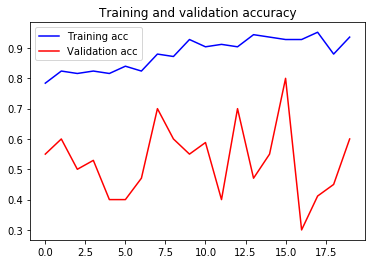

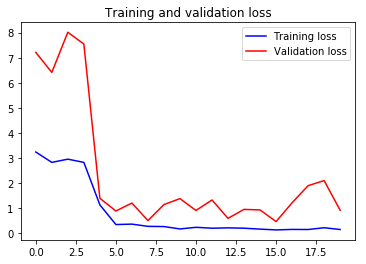

In [60]:
import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Abschließend werden die Gewichte und die verwendete Architektur gespeichert.

In [61]:
my_model.save("manuweightsfile.h5")
print('Gewichte gespeichert')

weight saved
